# Figure 1: Formation of doline on Amery Ice Shelf

a) Landsat-8 image over the southern Amery Ice Shelf on 17 January 2019; 
Landsat-8 images for 
(b) 31 March and 
(c) 14 September 2019, with color-coded ICESat-2 GTs overlaid; 
(d) to (k) ICESat-2 ATL06 data for repeats of GTs (from west to east) before and after doline formation.

In [1]:
%matplotlib notebook
import rasterio as rio
import datetime
from rasterio import plot
from rasterio import warp
from rasterio import Affine as A
from rasterio.enums import ColorInterp
from rasterio.windows import Window
from rasterio.windows import from_bounds
from rasterio.transform import TransformMethodsMixin
from rasterio.enums import Resampling
from rasterio.warp import reproject
from rasterio.crs import CRS
import os
from os import listdir, makedirs
from os.path import isfile, join, exists
# needed to set environment variables to make it work
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import pandas as pd
import geopandas as gpd
import numpy as np
import earthpy as et
import earthpy.spatial as es
from scipy import interpolate
from scipy.ndimage import gaussian_filter
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle as pkl
from mpl_toolkits.basemap import Basemap
from readers.read_ICESat2_ATL06 import read_HDF5_ATL06
import warnings
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore",category=RuntimeWarning)
from matplotlib.ticker import FormatStrFormatter
from curve_intersect import *
import shapely
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## sort out the ICESat-2 data for plotting

In [2]:
order = [6, 7, 4, 5, 0, 1, 2, 3]
rgt_list = [1095, 1095, 1095, 1095, 81, 81, 653, 653]
spot_list = ['1l', '1r', '2l', '2r', '1l', '1r', '3l', '3r']
date_list = [['2019-06-09', '2019-09-07'],
         ['2019-06-09', '2019-09-07'],
         ['2019-06-09', '2019-09-07'],
         ['2019-06-09', '2019-09-07'],
         ['2019-04-03', '2019-10-02'],
         ['2019-04-03', '2019-10-02'],
         ['2019-05-11', '2019-08-09'],
         ['2019-05-11', '2019-08-09']]

rgt_list = [rgt_list[i] for i in order]
spot_list = [spot_list[i] for i in order]
date_list = [date_list[i] for i in order]

## compile the ICESat-2 data

In [3]:
loadpickle = True
datapath = 'data/IS2/'
pklfn = 'compiledIS2dataFig1.pkl'

if loadpickle:
    with open(datapath + pklfn, 'rb') as f:
        dfs06, dfs03, dates, spots, rgts, nplt = pkl.load(f)
        
else:
    atl06files = [f for f in listdir(datapath) if isfile(join(datapath, f)) & ('.h5' in f) & ('ATL06' in f)]
    nplt = []
    rgts = []
    spots = []
    dates = []
    dfs06 = []
    dfs03 = []
    for j,rgt in enumerate(rgt_list):
        for k,date in enumerate(date_list[j]):
            atl06file = [datapath+f for f in atl06files if (f[16:24]==date.replace('-','')) & (f[31:35]==('%04i' % rgt))]
            atl06file = atl06file[0]
            IS2_atl06_mds, IS2_atl06_attrs, IS2_atl06_beams = read_HDF5_ATL06(atl06file)
            spot = 'gt%s' % spot_list[j]
            data06 = IS2_atl06_mds[spot]
            lat_gt = data06['land_ice_segments']['latitude']
            lon_gt = data06['land_ice_segments']['longitude']
            gt_transf = warp.transform({'init': 'epsg:4326'}, CRS.from_string('EPSG:3031'), lon_gt, lat_gt)
            h06 = data06['land_ice_segments']['h_li']
            h06[h06>1e5] = np.nan
            df06 = pd.DataFrame(list(zip(lat_gt,lon_gt,h06,gt_transf[0],gt_transf[1])),columns=['lat','lon','h','x_img','y_img'])
            dfs06.append(df06)
            nplt.append(j)
            spots.append(spot)
            dates.append(date)
            rgts.append(rgt)
            
    with open(datapath + pklfn, 'wb') as f:
        pkl.dump([dfs06, dfs03, dates, spots, rgts, nplt], f)
    

cmap = plt.rcParams['axes.prop_cycle'].by_key()['color'][0:4]
gtcols = []
for i in range(4):
    hsv = matplotlib.colors.rgb_to_hsv(matplotlib.colors.to_rgb(cmap[i]))
    gtcoll = matplotlib.colors.hsv_to_rgb(np.array([hsv[0],0.45,1]))
    gtcolr = matplotlib.colors.hsv_to_rgb(np.array([hsv[0],1,0.75]))
    gtcols.append(gtcoll)
    gtcols.append(gtcolr)

## produce the figure

<IPython.core.display.Javascript object>


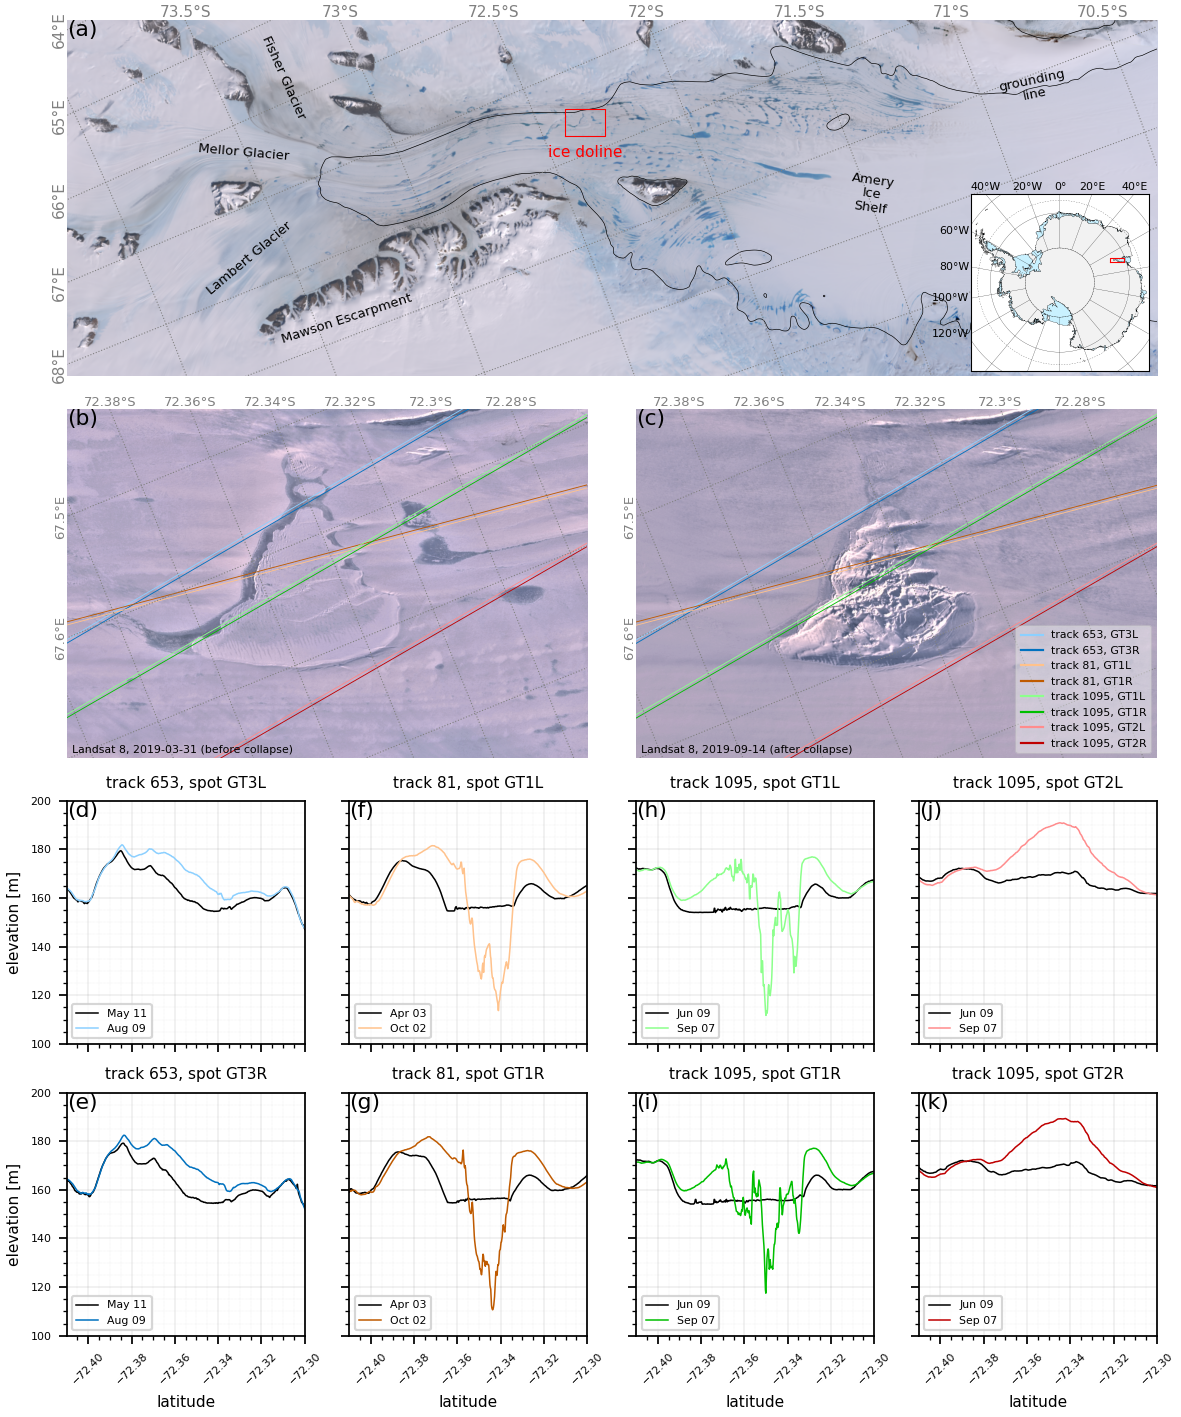

In [4]:
# saves figure at 300 dpi 
hi_res_output = False
fig_width = 7.5
fig_height = 9
    
# make figure with grid-spec
if hi_res_output:
    fig = plt.figure(figsize=[fig_width,fig_height], constrained_layout=True, dpi=600)
else:
    fig = plt.figure(figsize=[fig_width,fig_height], constrained_layout=True)

layout = (2,4,2,1)
gs = fig.add_gridspec(10, 4)
gs_scene = gs[:3,:]
gs_before = gs[3:6,:2]
gs_after = gs[3:6,2:]

#########################################################################################
# overview map
#########################################################################################
if hi_res_output:
    fn = 'data/L8/amery_mosaic_201901_med_8bit.tiff'
else:
    fn = 'data/L8/amery_mosaic_201901_xsmall_8bit.tiff'
xl = (1582591.0, 2014315.0)
# yl = (632693.0, 778926.0)
yl = (634926.0, 775724.0)
mosaic = rio.open(fn)

ax = fig.add_subplot(gs_scene)
plot.show(mosaic,ax=ax)
ax.axis('off')

ax.set_xlim(xl)
ax.set_ylim(yl)

# plot meridians and parallels
minlat = -75.0
maxlat = -70.0
latstep = 0.5
minlon = 64.0
maxlon = 72.0
lonstep = 1.0
meridians = np.arange(minlon,maxlon, step=lonstep)
parallels = np.arange(minlat,maxlat, step=latstep)
latseq = np.linspace(minlat,maxlat,200)
lonseq = np.linspace(minlon,maxlon,200)
gridcol = 'gray'
gridls = ':'
gridlw = 0.5
topline = [[xl[0],xl[1]],[yl[1],yl[1]]]
leftline = [[xl[0],xl[0]],[yl[0],yl[1]]]
for me in meridians:
    gr_trans = warp.transform({'init': 'epsg:4326'},mosaic.crs,me*np.ones_like(latseq),latseq)
    intx,inty = intersection(leftline[0], leftline[1], gr_trans[0], gr_trans[1])
    if len(intx) > 0:
        intx = intx[0]
        inty = inty[0]
        deglab = '%.10g°E' % me
        ax.text(intx, inty, deglab, fontsize=7, color='gray',verticalalignment='center',horizontalalignment='right',
                rotation='vertical')
    thislw = gridlw
    ax.plot(gr_trans[0],gr_trans[1],c=gridcol,ls=gridls,lw=thislw)
for pa in parallels:
    gr_trans = warp.transform({'init': 'epsg:4326'},mosaic.crs,lonseq,pa*np.ones_like(lonseq))
    thislw = gridlw
    deglab = '%.10g°S' % np.abs(pa)
    intx,inty = intersection(topline[0], topline[1], gr_trans[0], gr_trans[1])
    if len(intx) > 0:
        intx = intx[0]
        inty = inty[0]
        ax.text(intx, inty, deglab, fontsize=7, color='gray',verticalalignment='bottom',horizontalalignment='center')
    ax.plot(gr_trans[0],gr_trans[1],c=gridcol,ls=gridls,lw=thislw)
    
#########################################################################################
# inset map
gz_sio = gpd.read_file("data/siogz/scripps_antarctica_polygons_v1.shp")
gz_sio_latlon = gz_sio.to_crs(epsg=4326)
axmap = inset_axes(ax, width="17%", height="50%", loc=4, borderpad=0.2)

# use basemap with polar stereographic projection
lon_0 = 0.
lat_0 = -90.
m=Basemap(width=5600000., height=5600000., projection='stere',
          ellps='WGS84', lon_0=lon_0, lat_0=lat_0, lat_ts=-71.,resolution='l',ax=axmap)
m.drawparallels([-66.5, 66.5],color='k',linewidth=0.1, dashes=[6,6],fontsize=5)
m.drawparallels([-90,-80,-70,-60],color='k',linewidth=0.1, dashes=[1,0],fontsize=5)
m.drawmeridians(np.arange(-180.,180.,20.),labels=[1,0,1,0],color='k',latmax=80,linewidth=0.1, dashes=[1,0],
                textcolor='k',fontsize=5, bbox=dict(facecolor='white', alpha=0.0,boxstyle='round,pad=0.15',linewidth=0))
bb = warp.transform(mosaic.crs,{'init': 'epsg:4326'}, [xl[0],xl[0],xl[1],xl[1],xl[0]], [yl[0],yl[1],yl[1],yl[0],yl[0]])
x, y = m(bb[0],bb[1])
axmap.plot(x,y,'r-',lw=0.5)

allpatches = []
gz_sio_stere = gz_sio.to_crs(epsg=3031)
grounded_stere = gz_sio_stere[gz_sio_stere.Id < 4]
grounded_stere.boundary.plot(ax=ax,color='k',linewidth=0.3)
grounded = gz_sio_latlon[gz_sio_latlon.Id < 4]
shelves = gz_sio_latlon[gz_sio_latlon.Id.eq(4)]
for thing in [grounded, shelves]:
    patches = []
    for poly in thing.geometry:
        if poly.geom_type == 'Polygon':
            mpoly = shapely.ops.transform(m, poly)
            patches.append(PolygonPatch(mpoly))
        elif poly.geom_type == 'MultiPolygon':
            for subpoly in poly:
                mpoly = shapely.ops.transform(m, poly)
                patches.append(PolygonPatch(mpoly))
        else:
            print(poly, "is neither a polygon nor a multi-polygon. Skipping it.")
    allpatches.append(patches)
grounded_plot = axmap.add_collection(PatchCollection(allpatches[0], match_original=True))
grounded_plot.set_facecolor((0.95,0.95,0.95))
grounded_plot.set_linewidth(0.1)
shelves_plot = axmap.add_collection(PatchCollection(allpatches[1], match_original=True))
shelves_plot.set_facecolor((0.78823529, 0.94509804, 1.))
shelves_plot.set_linewidth(0.1)
for side in ['top','bottom','left','right']:
    axmap.spines[side].set_linewidth(0.5)
ax.text(0,1,'(a)',transform = ax.transAxes,verticalalignment='top',horizontalalignment='left',
           fontsize=10, fontweight='normal',color='black',bbox=dict(boxstyle='square,pad=1', fc='none', ec='none'))

#########################################################################################
# before and after collapse imagery of the doline
#########################################################################################
fn_before = 'data/L8/pansharpened/LC08_L1GT_126111_20190331_20190401_01_RT_pansharp_cropped_tci_8bit_edited.tiff'
fn_after = 'data/L8/pansharpened/LC08_L1GT_127111_20190914_20190914_01_RT_pansharp_cropped_tci_8bit_edited.tiff'
fns = [fn_before, fn_after]
gss = (gs_before, gs_after)
desc = ['before', 'after']
letters = 'bc'
# xl = (1778129.0, 1793737.0)
# yl = (730532.0, 740999.0)
xl = (1779994.0, 1795602.0)
yl = (730050.0, 740517.0)

# plot bounding box of these on the above map
ax.plot([xl[0],xl[0],xl[1],xl[1],xl[0]], [yl[0],yl[1],yl[1],yl[0],yl[0]],'r-',lw=0.5)

# for before and after
for i,fn in enumerate(fns):
    
    # get axes set up and plot imagery
    gs_img = gss[i]
    axz = fig.add_subplot(gs_img)
    thisImg = rio.open(fn)
    plot.show(thisImg,ax=axz)

    # plot ground tracks
    hdls = []
    for j,thisdf in enumerate(dfs06):
        if (i+j) % 2 == 0:
            lab = 'track %s, %s' % (rgts[j], spots[j].upper())
            if i == 0:
                thiscol = gtcols[nplt[j]]
            else:
                thiscol = gtcols[nplt[j]]
            axz.plot(thisdf.x_img, thisdf.y_img, c=thiscol, lw=0.4)
            hd, = axz.plot([0,0], [1,1], c=gtcols[nplt[j]], lw=1, label=lab) # for legend
            hdls.append(hd)

    # axes appearance and labels
    axz.axis('off')
    dt = fn[fn.find('LC08')+17:fn.find('LC08')+25]
    yr = dt[:4]
    mon = dt[4:6]
    day = dt[6:]
    date = '%s-%s-%s' % (yr,mon,day)
    axz.set_xlim(xl)
    axz.set_ylim(yl)
    axz.text(0.01, 0.01, 'Landsat 8, %s (%s collapse)' % (date,desc[i]), transform = axz.transAxes,
             verticalalignment='bottom', horizontalalignment='left', fontsize = 5)
    if i == 1:
        axz.legend(handles=hdls,loc='lower right',fontsize=5,framealpha=0.4)
    
    # plot meridians and parallels
    minlat = -72.5
    maxlat = -72.2
    latstep = 0.02
    minlon = 67.0
    maxlon = 68.2
    lonstep = 0.1
    meridians = np.arange(minlon,maxlon, step=lonstep)
    parallels = np.arange(minlat,maxlat, step=latstep)
    latseq = np.linspace(minlat,maxlat,200)
    lonseq = np.linspace(minlon,maxlon,200)
    gridcol = 'gray'
    gridls = ':'
    gridlw = 0.5
    topline = [[xl[0],xl[1]],[yl[1],yl[1]]]
    leftline = [[xl[0],xl[0]],[yl[0],yl[1]]]
    for me in meridians:
        gr_trans = warp.transform({'init': 'epsg:4326'},thisImg.crs,me*np.ones_like(latseq),latseq)
        intx,inty = intersection(leftline[0], leftline[1], gr_trans[0], gr_trans[1])
        if len(intx) > 0:
            intx = intx[0]
            inty = inty[0]
            deglab = '%.10g°E' % me
            axz.text(intx, inty, deglab, fontsize=6, color='gray',verticalalignment='center',horizontalalignment='right',
                    rotation='vertical')
        thislw = gridlw
        axz.plot(gr_trans[0],gr_trans[1],c=gridcol,ls=gridls,lw=thislw)
    for pa in parallels:
        gr_trans = warp.transform({'init': 'epsg:4326'},thisImg.crs,lonseq,pa*np.ones_like(lonseq))
        thislw = gridlw
        deglab = '%.10g°S' % np.abs(pa)
        intx,inty = intersection(topline[0], topline[1], gr_trans[0], gr_trans[1])
        if len(intx) > 0:
            intx = intx[0]
            inty = inty[0]
            axz.text(intx, inty, deglab, fontsize=6, color='gray',verticalalignment='bottom',horizontalalignment='center')
        axz.plot(gr_trans[0],gr_trans[1],c=gridcol,ls=gridls,lw=thislw)
        
    axz.text(0,1,'(%s)' % letters[i],transform = axz.transAxes,verticalalignment='top',horizontalalignment='left',
           fontsize=10, fontweight='normal',color='black')

#########################################################################################
# all the ICESat-2 tracks
#########################################################################################
gsstart = 6
labsz = 7
latls = (-72.41, -72.30)
hls = (100, 200)
letters = 'defghijk'
for i,rgt in enumerate(rgt_list):
    
    # get layout parameters in order
    rs = i % layout[0] * layout[2] + gsstart
    cs = np.int(i / layout[0]) * layout[3]
    re = rs+layout[2]
    ce = cs+layout[3]
    axp = fig.add_subplot(gs[rs:re,cs:ce])

    # plot elevation before
    j = i*2
    df = dfs06[j]
    df = df[df.h < 1e20]
    dt = datetime.datetime.strptime(dates[j], '%Y-%m-%d')
    h1, = axp.plot(df.lat,df.h,c='k',lw=0.7,ls='-',label=dt.strftime("%b %d"))
    
    # plot elevation after
    j = i*2+1
    df = dfs06[j]
    df = df[df.h < 1e20]
    dt = datetime.datetime.strptime(dates[j], '%Y-%m-%d')
    h2, = axp.plot(df.lat,df.h,c=gtcols[i],lw=0.7,ls='-',label=dt.strftime("%b %d"))
    
    # add axis labels where necessary
    if (i % layout[0]) == (layout[0]-1): 
        axp.set_xlabel('latitude',fontsize=labsz)
        plt.xticks(rotation=45)
    else: axp.axes.xaxis.set_ticklabels([])
    if np.int(i / layout[0]) == 0: 
        axp.set_ylabel('elevation [m]',fontsize=labsz)
    else: axp.axes.yaxis.set_ticklabels([])
    
    # axes appearance and labels
    axp.tick_params(axis='both', which='major', labelsize=5)
    axp.grid(b=True, which='major', color='gray', linestyle='-', linewidth=0.1)
    axp.minorticks_on()
    axp.grid(b=True, which='minor', color='gray', linestyle=':', alpha=0.5, linewidth=0.1)
    axp.set_xlim(latls)
    axp.set_ylim(hls)
    axp.legend(handles=[h1,h2],loc='lower left',fontsize=5)
    axp.set_title('track %s, spot GT%s' % (rgt_list[i],spot_list[i].upper()),fontsize=7)
    axp.text(0,1,'(%s)' % letters[i],transform = axp.transAxes,verticalalignment='top',horizontalalignment='left',
           fontsize=10, fontweight='normal',color='black')

# add map labels
labelsize = 6
ax.text(1652832.0, 723078.0, 'Mellor Glacier',rotation=-5,verticalalignment='center',horizontalalignment='center',fontsize=labelsize)
ax.text(1655208.0, 681239.0, 'Lambert Glacier',rotation=40,verticalalignment='center',horizontalalignment='center',fontsize=labelsize)
ax.text(1668474.0, 753113.0,'Fisher Glacier',rotation=-66,verticalalignment='center',horizontalalignment='center',fontsize=labelsize)
ax.text(1901323.0, 706781.0,'Amery\nIce\nShelf',rotation=-8,verticalalignment='center',horizontalalignment='center',fontsize=labelsize)
ax.text(1693422.0, 657529.0,'Mawson Escarpment',rotation=18,verticalalignment='center',horizontalalignment='center',fontsize=labelsize)
ax.text(1787766.0, 726185.0,'ice doline',verticalalignment='top',horizontalalignment='center',fontsize=labelsize+1,color='r')
ax.text(1965291.0, 748966.0,'grounding\nline',rotation=12,verticalalignment='center',horizontalalignment='center',fontsize=labelsize)

# save figure
if hi_res_output:
    plt.savefig('figs/Fig1_formation_of_doline_on_Amery_Ice_Shelf.jpg')